In [1]:
# import matplotlib
import math
import numpy as np
from graphviz import Digraph
import torch

In [2]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges


def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={
                'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (
        n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name=uid + n._op, label=n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [3]:
class Value:

    def __init__(self, data, _children=(),  _op='', label='', grad=0.0) -> None:
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = grad
        self._backward = lambda : None
        
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad +=  1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        out = self + (-other)
        return out
    
    def __rsub__(self, other):
        out = self + (-other)
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def __pow__(self, exponent):
        assert isinstance(exponent, (int, float)), "Only support int/float now"
        out = Value(self.data**exponent, (self, ), label=f'**{exponent}')

        def _backward():
            self.grad += exponent * self.data ** (exponent - 1) * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        out = self * other
        return out

    def __truediv__(self, other):
        out = self * other**-1
        return out
    
    def exp(self):
        out = Value(np.exp(self.data), (self, ), label='exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward    
        return out
    
    def tanh(self):
        n = self.data
        t = (np.exp(2*n) - 1) / (np.exp(2*n) + 1)
        out = Value(t, (self, ), label='tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    def relu(self):
        n = self.data
        r = max(0, n)
        out = Value(r, (self, ), label='ReLU')

        def _backward():
            self.grad += r * out.grad
        out.backward = _backward
        return out
    
    def backward(self):
        
        # topological sort
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # perform back propagation
        # last node os the final output
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

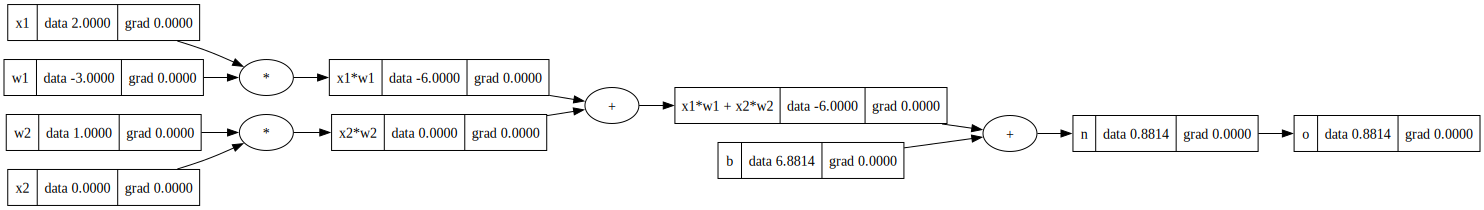

In [4]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'
o = n.relu()
o.label = 'o'

draw_dot(o)

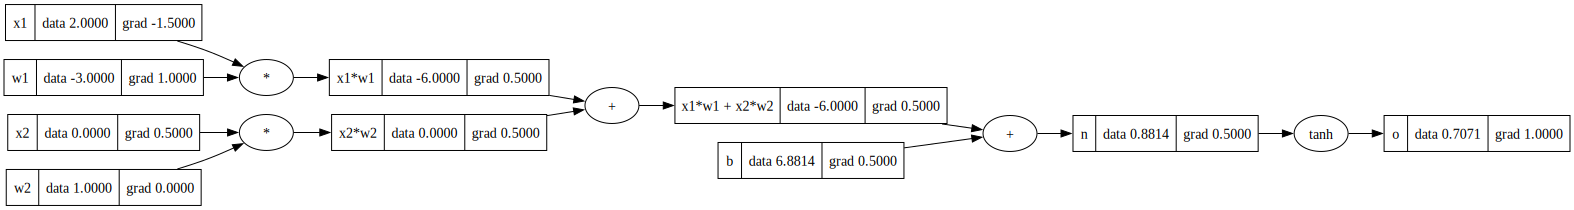

In [43]:
o.backward()
draw_dot(o)

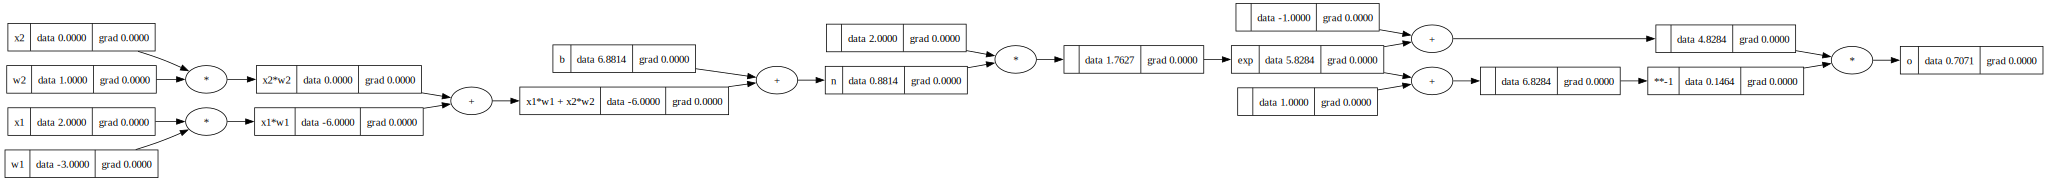

In [5]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'
e = (2 * n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

draw_dot(o)

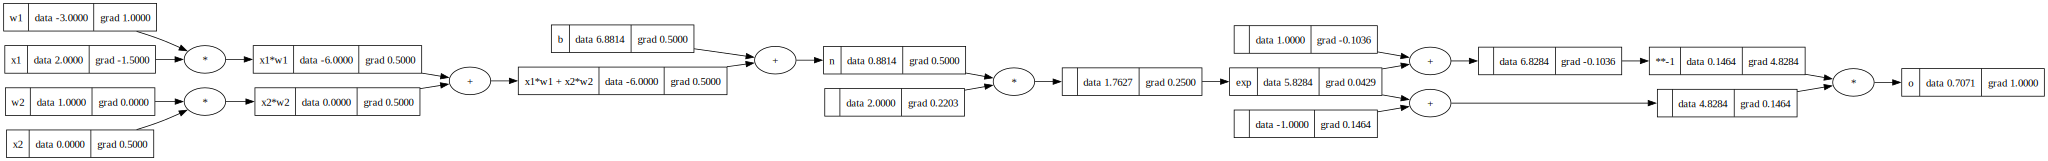

In [5]:
o.backward()
draw_dot(o)

In [7]:
x1 = torch.tensor([2.0]).double(); x1.requires_grad = True    
x2 = torch.tensor([0.0]).double(); x2.requires_grad = True
# weights w1,w2
w1 = torch.tensor([-3.0]).double(); w1.requires_grad = True    
w2 = torch.tensor([1.0]).double(); w2.requires_grad = True    
# bias of the neuron
b = torch.tensor([6.8813735870195432]).double(); b.requires_grad = True    

n = w1*x1 + w2*x2 + b
o = torch.tanh(n)
o.backward()

In [10]:
print(x1.grad.item())
print(x2.grad.item())
print(w1.grad.item())
print(w2.grad.item())

-1.5000003851533106
0.5000001283844369
1.0000002567688737
0.0


In [27]:
class Neuron:
    def __init__(self, nin, nonlin=True) -> None:
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1, 1))
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum(wi*xi for wi, xi in list(zip(self.w, x))) + self.b
        return act.relu() if self.nonlin else act.tanh()
    
    def parameters(self):
        return self.w + [self.b]
    
    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"
    

class Layer:
    def __init__(self, nin, nout, **kwargs) -> None:
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = [p for neuron in self.neurons for p in neuron.parameters()]
        return params
    
    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP:
    def __init__(self, nin, nouts) -> None:
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1], nonlin=(i != len(nouts) - 1)) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = [p for layer in self.layers for p in layer.parameters()]
        return params
    
    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

x = [1.0, 2.0, 3.0]
mlp = MLP(nin=3, nouts=[4, 4, 1])       

In [29]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [38]:
lr = 0.5
for i in range(40000):
    y_pred = [mlp(x) for x in xs]
    loss = sum([(y_real - y_out)**2 for y_real, y_out in zip(ys, y_pred)])

    if i % 500 == 0:
        print(f'Itr: {i + 1}, Loss: {loss}')

    for p in mlp.parameters():
        p.grad = 0

    loss.backward()

    for p in mlp.parameters():
        p.data -= 0.01 * p.grad

Itr: 1, Loss: Value(data=0.0004572052097619011)
Itr: 501, Loss: Value(data=0.00045512181500150905)
Itr: 1001, Loss: Value(data=0.0004530572969141654)
Itr: 1501, Loss: Value(data=0.0004510114003007402)
Itr: 2001, Loss: Value(data=0.00044898387453927045)
Itr: 2501, Loss: Value(data=0.0004469744734829053)
Itr: 3001, Loss: Value(data=0.00044498295536042414)
Itr: 3501, Loss: Value(data=0.0004430090826795721)
Itr: 4001, Loss: Value(data=0.0004410526221327267)
Itr: 4501, Loss: Value(data=0.00043911334450527455)
Itr: 5001, Loss: Value(data=0.00043719102458621443)
Itr: 5501, Loss: Value(data=0.0004352854410811916)
Itr: 6001, Loss: Value(data=0.00043339637652773484)
Itr: 6501, Loss: Value(data=0.0004315236172126931)
Itr: 7001, Loss: Value(data=0.00042966695309184355)
Itr: 7501, Loss: Value(data=0.00042782617771150043)
Itr: 8001, Loss: Value(data=0.00042600108813214575)
Itr: 8501, Loss: Value(data=0.00042419148485398875)
Itr: 9001, Loss: Value(data=0.0004223971717444713)
Itr: 9501, Loss: Value(da

In [39]:
y_pred

[Value(data=0.9964863562777204),
 Value(data=-0.9977792929092577),
 Value(data=-0.9881152303033706),
 Value(data=0.98672997110694)]